In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import torch.optim as optim
import CONSTANTS
from functions import *
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.base import clone
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
COIN = 'BTC'
data = pd.read_csv(fullDataPath(COIN))
data

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,date,link,text,sentiment,score
0,2024-05-08,60851.04,63013.05,62315.75,61169.53,7486.425968,-1146.22,-1.839374,65890.2210,66417.9682,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
1,2024-05-09,60601.60,63424.14,61169.53,63073.57,8360.055382,1904.04,3.112726,66247.8435,66426.8854,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
2,2024-05-10,60150.00,63470.00,63073.55,60787.47,11511.129910,-2286.08,-3.624467,66472.6375,66371.6810,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
3,2024-05-11,60450.13,61482.00,60787.99,60814.63,2338.068108,26.64,0.043824,66850.1930,66373.6450,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
4,2024-05-12,60576.05,61843.45,60814.64,61453.02,2694.975779,638.38,1.049714,67183.0820,66410.7176,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,2025-05-03,95765.13,96974.78,96929.81,95861.33,2077.556760,-1068.48,-1.102323,72647.6545,69787.8322,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
433,2025-05-04,94151.67,96312.51,95865.47,94272.55,2834.396865,-1592.92,-1.661620,71251.6105,69155.3058,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
434,2025-05-05,93500.01,95218.82,94272.54,94733.99,5180.158939,461.45,0.489485,69965.3730,68533.2834,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0
435,2025-05-06,93363.28,96916.25,94733.99,96839.17,6163.867558,2105.18,2.222201,68693.1570,67843.8636,...,0.0,0.0,0.0,0.0,-,NaN,-,-,-,0.0


In [3]:
data['time'] = pd.to_datetime(data['time'], errors='coerce')
data = data.dropna(subset=['time'])  # optional: drop rows where parsing failed
data['date'] = data['time'].dt.date

# 3.4) Coerce any non-numeric sentiment scores to NaN, then drop those rows:
data['score'] = pd.to_numeric(data['score'], errors='coerce')
data = data.dropna(subset=['score'])

daily_sent = (
    data
    .groupby('date')
    .agg(
        avg_sentiment=('score', 'mean'),
        tweet_count=('score', 'size')
    )
    .reset_index()
)
daily_sent = daily_sent.set_index('date').sort_index()
daily_sent

,avg_sentiment,tweet_count
date,,
2024-05-08,0.0,1
2024-05-09,0.0,1
2024-05-10,0.0,1
2024-05-11,0.0,1
2024-05-12,0.0,1
...,...,...
2025-05-03,0.0,1
2025-05-04,0.0,1
2025-05-05,0.0,1


# XGBoost Implementation

In [4]:
merged = pd.merge(daily_sent, data, on='date')
print(merged.shape)
merged['gradient'] = merged['close'].diff().fillna(0.0)
merged[['date', 'avg_sentiment', 'tweet_count']]

(437, 38)


,date,avg_sentiment,tweet_count
0,2024-05-08,0.0,1
1,2024-05-09,0.0,1
2,2024-05-10,0.0,1
3,2024-05-11,0.0,1
4,2024-05-12,0.0,1
...,...,...,...
432,2025-05-03,0.0,1
433,2025-05-04,0.0,1
434,2025-05-05,0.0,1
435,2025-05-06,0.0,1


<Axes: >

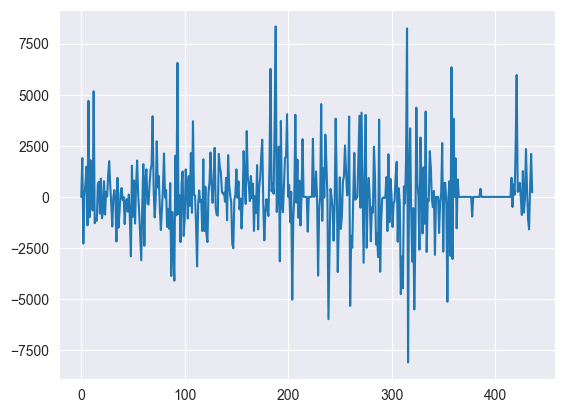

In [5]:
merged['gradient'].plot.line()

In [6]:
class XGBoost(BaseEstimator, RegressorMixin):
    """
    Custom implementation of XGBoost algorithm with gradient boosting
    """
    
    def __init__(self, base_estimator=None, n_estimators=100, learning_rate=0.1, 
                 max_depth=3, subsample=1.0, reg_lambda=1.0, reg_alpha=0.0, 
                 random_state=None):
        """
        Initialize XGBoost implementation
        
        Parameters:
        -----------
        base_estimator : sklearn estimator, default=None
            Base model to use for boosting. If None, uses DecisionTreeRegressor
        n_estimators : int, default=100
            Number of boosting rounds
        learning_rate : float, default=0.1
            Step size shrinkage to prevent overfitting
        max_depth : int, default=3
            Maximum depth of base estimators
        subsample : float, default=1.0
            Subsample ratio of training instances
        reg_lambda : float, default=1.0
            L2 regularization term
        reg_alpha : float, default=0.0
            L1 regularization term
        random_state : int, default=None
            Random state for reproducibility
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.reg_lambda = reg_lambda
        self.reg_alpha = reg_alpha
        self.random_state = random_state
        
        # Initialize containers for models and training history
        self.estimators_ = []
        self.train_scores_ = []
        self.feature_importances_ = None
        if base_estimator is None:
            self.base_estimator = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state
            )
        
    def _get_base_estimator(self):
        """Get base estimator with proper configuration"""
        if self.base_estimator is None:
            return DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state
            )
        else:
            # Clone the base estimator
            return clone(self.base_estimator)
    
    def _compute_gradients(self, y_true, y_pred):
        """
        Compute gradients for gradient boosting
        Using squared loss: L(y, F) = (y - F)^2 / 2
        Gradient: -dL/dF = y - F (residuals)
        """
        return y_true - y_pred
    
    def _compute_hessians(self, y_true, y_pred):
        """
        Compute second derivatives (Hessians)
        For squared loss: d²L/dF² = 1
        """
        return np.ones_like(y_true)
    
    def _subsample_data(self, X, gradients, hessians):
        """Apply subsampling to training data"""
        if self.subsample < 1.0:
            n_samples = int(len(X) * self.subsample)
            np.random.seed(self.random_state)
            indices = np.random.choice(len(X), n_samples, replace=False)
            return X.iloc[indices], gradients[indices], hessians[indices]
        return X, gradients, hessians
    
    def fit(self, X, y):
        """
        Fit the XGBoost model
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Training features
        y : pandas.Series
            Training targets
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Convert to numpy arrays for easier manipulation
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y
        
        # Initialize prediction with zeros (or mean)
        y_pred = np.zeros(len(y_array))
        
        # Store training scores
        self.train_scores_ = []
        
        # Boosting iterations
        for i in range(self.n_estimators):
            # Compute gradients and hessians
            gradients = self._compute_gradients(y_array, y_pred)
            hessians = self._compute_hessians(y_array, y_pred)
            
            # Apply subsampling
            X_sub, grad_sub, hess_sub = self._subsample_data(
                X if isinstance(X, pd.DataFrame) else pd.DataFrame(X_array), 
                gradients, hessians
            )
            
            # Fit base estimator on gradients (pseudo-residuals)
            estimator = self._get_base_estimator()
            estimator.fit(X_sub, grad_sub)
            
            # Make predictions with current estimator
            tree_pred = estimator.predict(X_array)
            
            # Apply learning rate and update predictions
            y_pred += self.learning_rate * tree_pred
            
            # Store estimator
            self.estimators_.append(estimator)
            
            # Calculate and store training score
            mse = mean_squared_error(y_array, y_pred)
            self.train_scores_.append(mse)
            
            # Early stopping could be implemented here
            if i > 10 and abs(self.train_scores_[-1] - self.train_scores_[-2]) < 1e-6:
                print(f"Early stopping at iteration {i}")
                break
        
        # Compute feature importances (average from all trees)
        self._compute_feature_importances(X)
        
        return self
    
    def _compute_feature_importances(self, X):
        """Compute feature importances from all estimators"""
        if hasattr(self.estimators_[0], 'feature_importances_'):
            n_features = X.shape[1]
            importances = np.zeros(n_features)
            
            for estimator in self.estimators_:
                importances += estimator.feature_importances_
            
            self.feature_importances_ = importances / len(self.estimators_)
    
    def predict(self, X):
        """
        Make predictions using the fitted model
        
        Parameters:
        -----------
        X : pandas.DataFrame or numpy.array
            Features to predict on
            
        Returns:
        --------
        predictions : numpy.array
            Predicted values
        """
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        predictions = np.zeros(len(X_array))
        
        for estimator in self.estimators_:
            predictions += self.learning_rate * estimator.predict(X_array)
            
        return predictions
    
    def cross_validate(self, X, y, cv=5, scoring='neg_mean_squared_error', 
                      return_train_score=False):
        """
        Perform cross-validation on the model
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Training features
        y : pandas.Series  
            Training targets
        cv : int, default=5
            Number of cross-validation folds
        scoring : str, default='neg_mean_squared_error'
            Scoring metric
        return_train_score : bool, default=False
            Whether to return training scores
            
        Returns:
        --------
        cv_results : dict
            Dictionary containing cross-validation results
        """
        kfold = KFold(n_splits=cv, shuffle=True, random_state=self.random_state)
        
        test_scores = []
        train_scores = [] if return_train_score else None
        
        for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
            print(f"Processing fold {fold + 1}/{cv}")
            
            # Split data
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Create and fit model for this fold
            model = XGBoost(
                base_estimator=self.base_estimator,
                n_estimators=self.n_estimators,
                learning_rate=self.learning_rate,
                max_depth=self.max_depth,
                subsample=self.subsample,
                reg_lambda=self.reg_lambda,
                reg_alpha=self.reg_alpha,
                random_state=self.random_state
            )
            
            model.fit(X_train, y_train)
            
            # Score on test set
            y_pred_test = model.predict(X_test)
            print(y_pred_test)
            test_score = mean_squared_error(y_test, y_pred_test)  # Negative for consistency
            test_score **= 0.5
            test_scores.append(test_score)
            
            # Score on train set if requested
            if return_train_score:
                y_pred_train = model.predict(X_train)
                train_score = mean_squared_error(y_train, y_pred_train)
                train_score **= 0.5
                train_scores.append(train_score)
        
        # Prepare results
        cv_results = {
            'test_scores': np.array(test_scores),
            'test_score_mean': np.mean(test_scores),
            'test_score_std': np.std(test_scores)
        }
        
        if return_train_score:
            cv_results.update({
                'train_scores': np.array(train_scores),
                'train_score_mean': np.mean(train_scores),
                'train_score_std': np.std(train_scores)
            })
        
        return cv_results
    
    def get_params(self, deep=True):
        """Get parameters for this estimator"""
        return {
            'base_estimator': self.base_estimator,
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'subsample': self.subsample,
            'reg_lambda': self.reg_lambda,
            'reg_alpha': self.reg_alpha,
            'random_state': self.random_state
        }
    
    def set_params(self, **params):
        """Set parameters for this estimator"""
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    def tune_hyperparameters(self, X, y, param_grid=None, cv=5, scoring='rmse', 
                           verbose=True, n_jobs=1):
        """
        Perform grid search cross-validation for hyperparameter tuning
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Training features
        y : pandas.Series
            Training targets
        param_grid : dict, default=None
            Dictionary with parameters names as keys and lists of parameter settings.
            If None, uses a default parameter grid.
        cv : int, default=5
            Number of cross-validation folds
        scoring : str, default='rmse'
            Scoring metric ('rmse' or 'mse')
        verbose : bool, default=True
            Whether to print progress
        n_jobs : int, default=1
            Number of parallel jobs (placeholder for future implementation)
            
        Returns:
        --------
        best_params : dict
            Best parameters found
        """
        from sklearn.model_selection import ParameterGrid
        import time
        
        # Default parameter grid if none provided
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 150],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'subsample': [0.8, 1.0],
                'reg_lambda': [0.1, 1.0, 2.0]
            }
        
        if verbose:
            print("Starting Hyperparameter Tuning...")
            print(f"Parameter grid size: {len(list(ParameterGrid(param_grid)))}")
            print(f"Using {cv}-fold cross-validation")
        
        best_score = float('inf')  # We want to minimize RMSE/MSE
        best_params = None
        all_results = []
        
        start_time = time.time()
        
        # Iterate through all parameter combinations
        for i, params in enumerate(ParameterGrid(param_grid)):
            if verbose and i % 5 == 0:
                print(f"Testing parameter combination {i+1}/{len(list(ParameterGrid(param_grid)))}")
                print(f"Current params: {params}")
            
            # Create model with current parameters
            model = XGBoost(**params, random_state=self.random_state)
            
            # Perform cross-validation
            kfold = KFold(n_splits=cv, shuffle=True, random_state=self.random_state)
            fold_scores = []
            
            for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
                # Split data
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # Fit and predict
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Calculate score
                if scoring == 'rmse':
                    score = mean_squared_error(y_test, y_pred) ** 0.5
                else:  # mse
                    score = mean_squared_error(y_test, y_pred)
                
                fold_scores.append(score)
            
            # Calculate mean score for this parameter combination
            mean_score = np.mean(fold_scores)
            std_score = np.std(fold_scores)
            
            # Store results
            result = {
                'params': params.copy(),
                'mean_score': mean_score,
                'std_score': std_score,
                'individual_scores': fold_scores.copy()
            }
            all_results.append(result)
            
            # Update best parameters
            if mean_score < best_score:
                best_score = mean_score
                best_params = params.copy()
                
                if verbose:
                    print(f"New best score: {best_score:.4f} (+/- {std_score:.4f})")
                    print(f"Best params so far: {best_params}")
        
        # Sort results by score
        all_results.sort(key=lambda x: x['mean_score'])
        
        # Store results in the instance
        self.best_params_ = best_params
        self.best_score_ = best_score
        self.tuning_results_ = all_results
        
        if verbose:
            elapsed_time = time.time() - start_time
            print(f"\nHyperparameter tuning completed in {elapsed_time:.2f} seconds")
            print(f"Best {scoring.upper()}: {best_score:.4f}")
            print(f"Best parameters: {best_params}")
            
            # Show top 3 results
            print(f"\nTop 3 parameter combinations:")
            for i, result in enumerate(all_results[:3]):
                print(f"{i+1}. Score: {result['mean_score']:.4f} (+/- {result['std_score']:.4f})")
                print(f"   Params: {result['params']}")
        
        return best_params
    
    def get_tuning_results(self):
        """
        Get detailed tuning results as a pandas DataFrame
        
        Returns:
        --------
        results_df : pandas.DataFrame
            DataFrame containing all parameter combinations and their scores
        """
        if not self.tuning_results_:
            print("No tuning results available. Run tune_hyperparameters() first.")
            return None
        
        # Flatten the results for DataFrame creation
        flattened_results = []
        for result in self.tuning_results_:
            flat_result = result['params'].copy()
            flat_result['mean_score'] = result['mean_score']
            flat_result['std_score'] = result['std_score']
            flattened_results.append(flat_result)
        
        results_df = pd.DataFrame(flattened_results)
        results_df = results_df.sort_values('mean_score').reset_index(drop=True)
        results_df['rank'] = range(1, len(results_df) + 1)
        
        return results_df
    
    def fit_best(self, X, y):
        """
        Fit the model using the best parameters found during tuning
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Training features
        y : pandas.Series
            Training targets
            
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        if self.best_params_ is None:
            raise ValueError("No best parameters available. Run tune_hyperparameters() first.")
        
        # Update parameters with best found parameters
        for param, value in self.best_params_.items():
            setattr(self, param, value)
        
        # Fit with best parameters
        return self.fit(X, y)


In [7]:
trainingCols = [i.strip() for i in open('training_columns.txt', 'r').readlines()]
percentage = 0.8
X = merged[trainingCols]
y = merged['gradient']
n = len(data)


line = int(percentage*n)
X_train = X.iloc[:line].reset_index(drop=True)
X_test = X.iloc[line:].reset_index(drop=True)
y_train = y.iloc[:line].reset_index(drop=True)
y_test = y.iloc[line:].reset_index(drop=True)

y_train

0         0.00
1      1904.04
2     -2286.10
3        27.16
4       638.39
        ...   
344       0.00
345       0.00
346   -1764.97
347    -236.85
348     154.34
Name: gradient, Length: 349, dtype: float64

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit model
xgb_model = XGBoost(
    base_estimator=RandomForestRegressor(n_estimators=50),
    n_estimators=50,
    learning_rate=0.1,
    max_depth=8,
    random_state=42
)
items = xgb_model.cross_validate(X_train, y_train, cv=5)

Processing fold 1/5
[  361.55599082   576.68694021  -459.25160966   -70.7641605
   174.00730093   197.78447893   349.63239486   297.72928887
   414.30645008 -1208.99663814  -517.79423674   -91.88296451
  -304.73839563  -798.23948222  -258.33974087  -122.65236415
   460.78584624   398.1132754    288.28164711  -433.21128437
   613.12840774   -98.37408793  1384.47273474  -447.73628042
  -965.8028687   -504.67991418  -912.61675896 -1314.38184633
  -884.52070667  -597.40449885   258.40361111   -16.58804627
    -6.89469871  -373.36554363  -508.03615078  -314.16217488
   673.43425009   635.456643      33.63844827   -69.80192798
  1207.02480875   752.65969556  1967.19276809  -350.23669032
    34.50078905 -1184.85778137   -34.15268245   -42.72381626
  2877.36824668  2384.43313384   614.92814911 -2804.74589255
   851.64912913 -1582.06330604   729.46668639   -83.6318261
   455.43402808  -850.61203837 -1428.22488297  -543.92300203
  -923.86492597  1348.88415831   783.66042014 -1889.17051638
    59

In [9]:
items

{'test_scores': array([2227.38776635, 1959.78176206, 1913.20111824, 2356.10576566,
        2187.45852858]),
 'test_score_mean': 2128.7869881774377,
 'test_score_std': 167.2592738679471}

In [10]:
items['test_score_mean']/merged['gradient'].std()

1.1296659025363271

In [11]:
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
predictions

array([ -125.40801024,  1004.82155094,  -297.12288834,   117.75082668,
         -51.52101294,   -79.34224753,   -79.34224753, -1078.27311336,
         566.83968998, -1118.77568764,  -219.12647234,  -521.17234689,
        -521.17234689, -1257.6656078 ,  -982.83815871,  -909.65337615,
        -909.65337615,  -909.65337615,  -909.65337615,  -909.65337615,
        -909.65337615,  -909.65337615,  -909.65337615,  -909.65337615,
        -909.65337615,  -909.65337615,  -909.65337615,  -909.65337615,
        -909.65337615,  -742.35189474,  -742.35189474,  -742.35189474,
        -742.35189474,  -742.35189474,  -742.35189474,  -742.35189474,
        -742.35189474, -1066.72085138, -1066.72085138, -1066.72085138,
       -1066.72085138, -1066.72085138, -1066.72085138, -1066.72085138,
       -1066.72085138, -1066.72085138, -1066.72085138, -1066.72085138,
       -1066.72085138, -1066.72085138, -1066.72085138, -1066.72085138,
       -1066.72085138, -1066.72085138, -1066.72085138, -1066.72085138,
      

<Axes: >

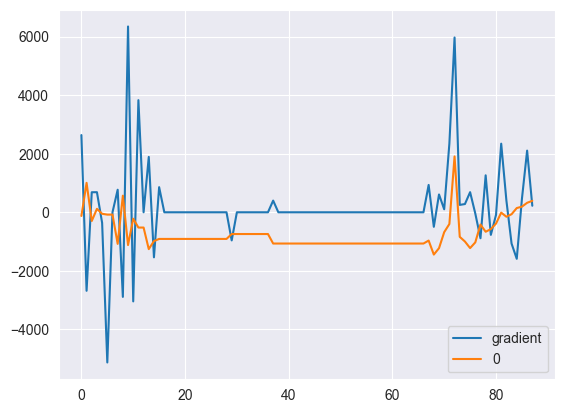

In [12]:
comparison = pd.DataFrame(predictions, y_test).reset_index()
comparison.plot.line()

In [13]:
custom_param_grid = {
        'n_estimators': [30, 50, 100],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 5, 8, 15],
        'subsample': [0.8, 1.0]
    }
xgb_model.tune_hyperparameters(X_train, y_train, param_grid=custom_param_grid, cv=5)

Starting Hyperparameter Tuning...
Parameter grid size: 72
Using 5-fold cross-validation
Testing parameter combination 1/72
Current params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 30, 'subsample': 0.8}
New best score: 1846.6422 (+/- 207.5593)
Best params so far: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 30, 'subsample': 0.8}
New best score: 1787.9281 (+/- 232.3164)
Best params so far: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 30, 'subsample': 1.0}
Testing parameter combination 6/72
Current params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Testing parameter combination 11/72
Current params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Testing parameter combination 16/72
Current params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 50, 'subsample': 1.0}
Testing parameter combination 21/72
Current params: {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 50, '

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 30, 'subsample': 1.0}

In [14]:
xgb_model.fit_best(X_train, y_train)
y_pred = xgb_model.predict(X_test)
comparison = pd.DataFrame(predictions, y_test).reset_index()

<Axes: >

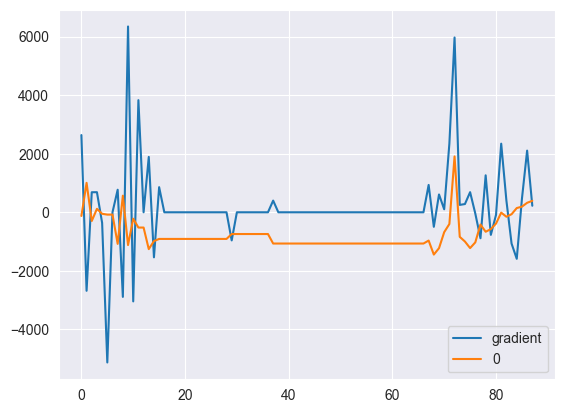

In [15]:
comparison.plot.line()